# Installing dependencies 

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


For this task, we'll use dataset from Kaggle, available [here](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?select=simpsons_dataset).

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/archive.zip

In [7]:
!ls simpsons_dataset

abraham_grampa_simpson	  edna_krabappel	marge_simpson	     professor_john_frink
agnes_skinner		  fat_tony		martin_prince	     rainier_wolfcastle
apu_nahasapeemapetilon	  gil			mayor_quimby	     ralph_wiggum
barney_gumble		  groundskeeper_willie	milhouse_van_houten  selma_bouvier
bart_simpson		  homer_simpson		miss_hoover	     sideshow_bob
carl_carlson		  kent_brockman		moe_szyslak	     sideshow_mel
charles_montgomery_burns  krusty_the_clown	ned_flanders	     simpsons_dataset
chief_wiggum		  lenny_leonard		nelson_muntz	     snake_jailbird
cletus_spuckler		  lionel_hutz		otto_mann	     troy_mcclure
comic_book_guy		  lisa_simpson		patty_bouvier	     waylon_smithers
disco_stu		  maggie_simpson	principal_skinner


In [8]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Sep 10 07:15:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In test dataset there will be 990 images for we'll need to predict the class.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    A dataset with images that loads them from folders in parallel and
    produces scaling and transformation into torch  tensors
    """
    def __init__(self, files, mode, include_augmented=True):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.include_augmented = include_augmented

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

        # determination of augmentations for the training regimen
        if self.mode == 'train':
            self.augmentation = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.augmentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        if self.include_augmented and self.mode == 'train':
            self.len_ *= 2

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.include_augmented and index >= len(self.files):
            is_augmented = True
            index = index % len(self.files)
        else:
            is_augmented = False

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)

        if is_augmented:
            x = self.augmentation(x) 
        else:
            x = transforms.ToTensor()(x)
            x = self.augmentation.transforms[-1](x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('./simpsons_dataset/')
TEST_DIR = Path('./kaggle_simpson_testset/kaggle_simpson_testset/')

In [14]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [15]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [16]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's take a look at our heroes inside the dataset

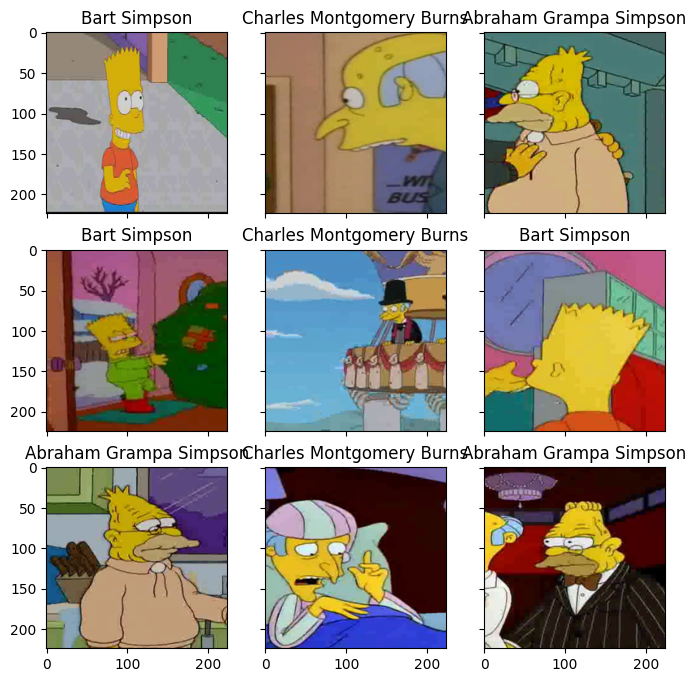

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Define Neural Network

In [18]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Add pooling
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Add pooling
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Add pooling
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Add pooling
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Add pooling
        )

        self.out = nn.Linear(128 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
    before_lr {bef_lr:0.5f} after_lr {aft_lr:0.5f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = CosineAnnealingLR(opt, T_max=10)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            before_lr = opt.param_groups[0]["lr"]
            scheduler.step()
            after_lr = opt.param_groups[0]["lr"]

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc,\
                                           v_acc=val_acc, bef_lr=before_lr,\
                                           aft_lr=after_lr))

    return history

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Let's run models training process

In [25]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

We will try some basic training to set the baseline

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.096214138552992


epoch:  50%|█████     | 1/2 [09:37<09:37, 577.31s/it]


Epoch 001 train_loss: 2.0962     val_loss 1.2171 train_acc 0.4237 val_acc 0.6723
loss 0.9084198865136044


epoch: 100%|██████████| 2/2 [14:23<00:00, 431.94s/it]


Epoch 002 train_loss: 0.9084     val_loss 0.7171 train_acc 0.7481 val_acc 0.8070


Let's look at learning curves 

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

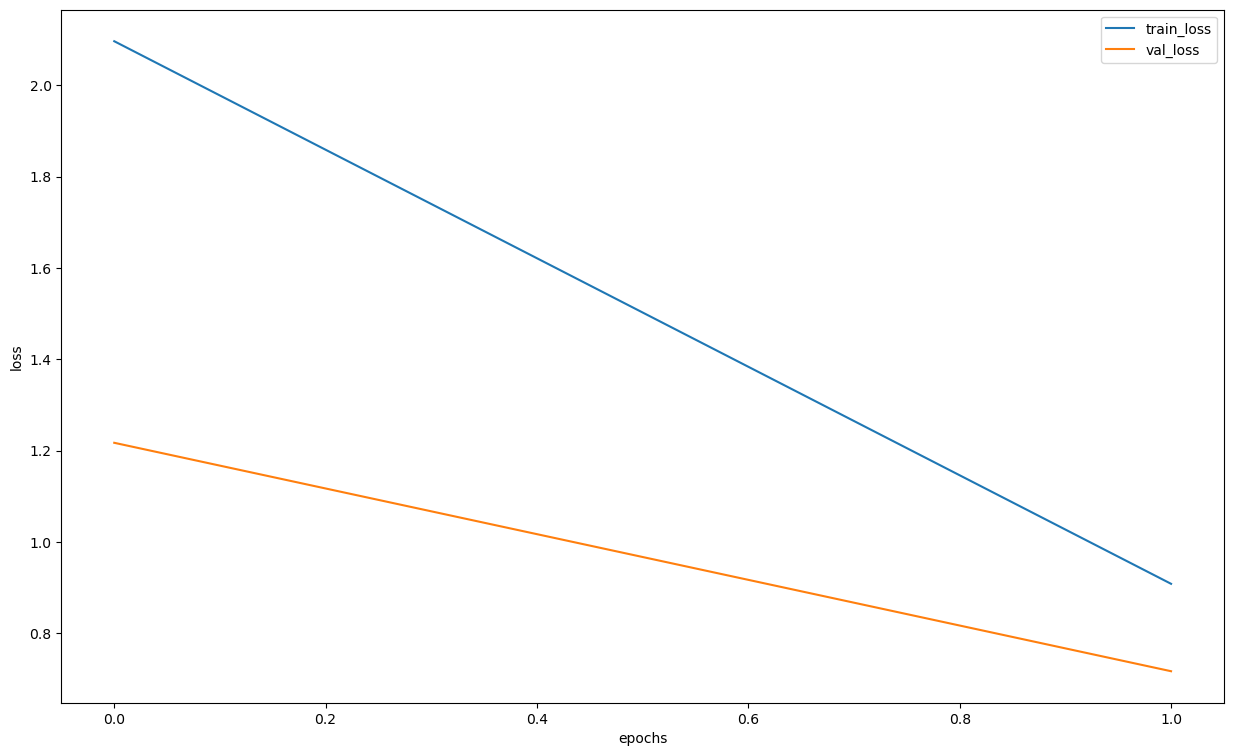

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Predict one sample"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Main metric we'll use is F1

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1 score:", f1)

F1 score: 0.85


Let's create a better visualisation for several test samples

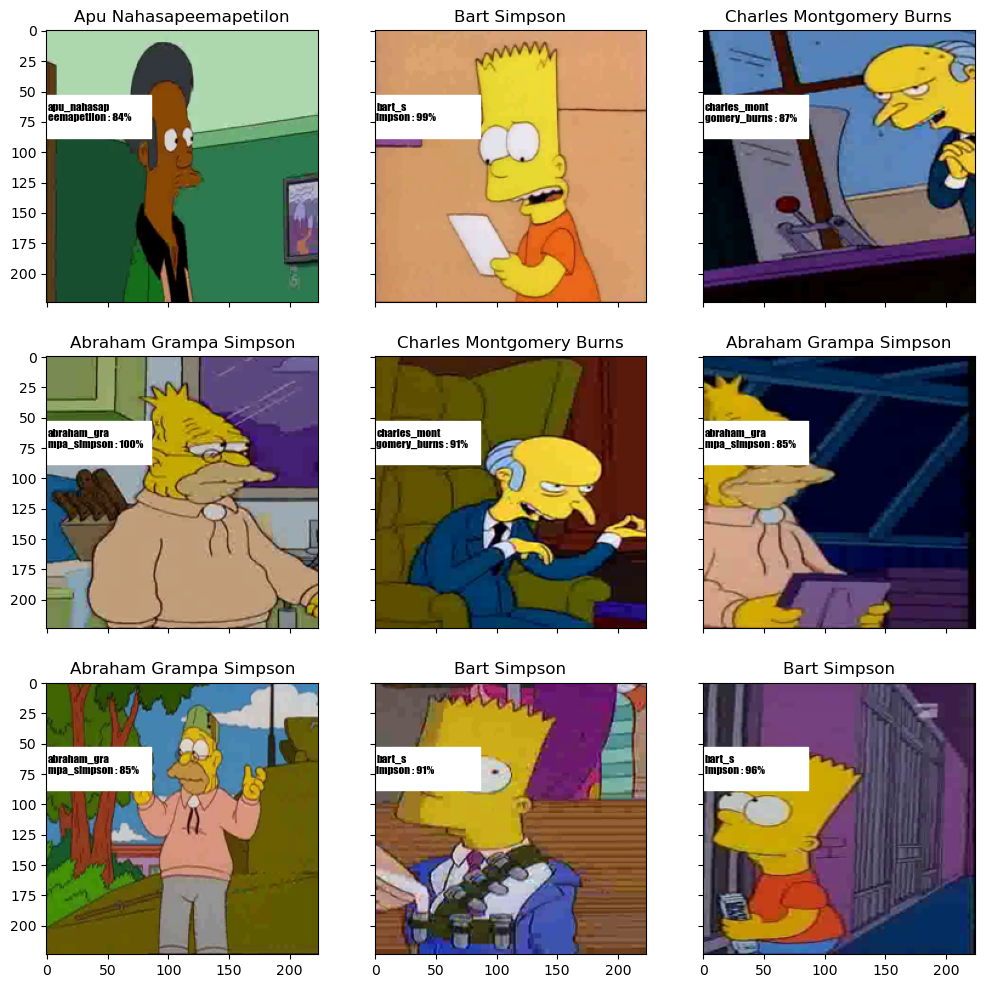

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Experimenting

Here we will try to get better results, using various techniques like parameters tunning or by modificating models architecture

Firstly, we will experiment with the values ​​of the number of epochs (set a sufficiently large number of epochs, and from the loss graph we can see the number of epochs that will be considered sufficient) for training and the batch size (usually the batch size is increased so that a larger number of pictures of different classes fall into 1 batch. Since we have 42 classes,
a batch size of 64 will be sufficient)\
Also, other hyperparameters of the model were changed, such as the number of input and output elements for each of the layers\
P.S.: architectures of the models were changed in one node, so the current one architecture used will be displayed before training started

In [ ]:
simple_cnn_1 = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn_1)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3200, out_features=42, bias=Tru

In [ ]:
history_cnn_1 = train(train_dataset, val_dataset, model=simple_cnn_1, epochs=15, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.784563494421896


epoch:   7%|▋         | 1/15 [04:48<1:07:17, 288.36s/it]


Epoch 001 train_loss: 1.7846     val_loss 0.9441 train_acc 0.5093 val_acc 0.7426
loss 0.6402814349473944


epoch:  13%|█▎        | 2/15 [09:16<59:53, 276.41s/it]


Epoch 002 train_loss: 0.6403     val_loss 0.5113 train_acc 0.8252 val_acc 0.8652
loss 0.3058366751760247


epoch:  20%|██        | 3/15 [13:58<55:47, 278.92s/it]


Epoch 003 train_loss: 0.3058     val_loss 0.3732 train_acc 0.9129 val_acc 0.9042
loss 0.16818852001339193


epoch:  27%|██▋       | 4/15 [18:43<51:34, 281.28s/it]


Epoch 004 train_loss: 0.1682     val_loss 0.3075 train_acc 0.9507 val_acc 0.9276
loss 0.11102333512116744


epoch:  33%|███▎      | 5/15 [23:47<48:17, 289.73s/it]


Epoch 005 train_loss: 0.1110     val_loss 0.3149 train_acc 0.9667 val_acc 0.9335
loss 0.08508650050712845


epoch:  40%|████      | 6/15 [28:40<43:36, 290.76s/it]


Epoch 006 train_loss: 0.0851     val_loss 0.2820 train_acc 0.9740 val_acc 0.9443
loss 0.0715791002642505


epoch:  47%|████▋     | 7/15 [33:25<38:30, 288.86s/it]


Epoch 007 train_loss: 0.0716     val_loss 0.2957 train_acc 0.9777 val_acc 0.9451
loss 0.06072014341550673


epoch:  53%|█████▎    | 8/15 [37:51<32:51, 281.58s/it]


Epoch 008 train_loss: 0.0607     val_loss 0.3307 train_acc 0.9813 val_acc 0.9451
loss 0.057176805801094986


epoch:  60%|██████    | 9/15 [42:16<27:38, 276.38s/it]


Epoch 009 train_loss: 0.0572     val_loss 0.3308 train_acc 0.9827 val_acc 0.9409
loss 0.0492541045649296


epoch:  67%|██████▋   | 10/15 [46:45<22:49, 273.93s/it]


Epoch 010 train_loss: 0.0493     val_loss 0.3519 train_acc 0.9849 val_acc 0.9476
loss 0.047398465721658546


epoch:  73%|███████▎  | 11/15 [51:10<18:05, 271.33s/it]


Epoch 011 train_loss: 0.0474     val_loss 0.3721 train_acc 0.9854 val_acc 0.9443
loss 0.0478251488758262


epoch:  80%|████████  | 12/15 [55:35<13:28, 269.46s/it]


Epoch 012 train_loss: 0.0478     val_loss 0.3333 train_acc 0.9855 val_acc 0.9541
loss 0.037866792181257776


epoch:  87%|████████▋ | 13/15 [1:00:01<08:56, 268.26s/it]


Epoch 013 train_loss: 0.0379     val_loss 0.3986 train_acc 0.9890 val_acc 0.9511
loss 0.029411306490570787


epoch:  93%|█████████▎| 14/15 [1:04:28<04:28, 268.07s/it]


Epoch 014 train_loss: 0.0294     val_loss 0.4106 train_acc 0.9914 val_acc 0.9514
loss 0.04540796332240324


epoch: 100%|██████████| 15/15 [1:08:52<00:00, 275.52s/it]


Epoch 015 train_loss: 0.0454     val_loss 0.3264 train_acc 0.9861 val_acc 0.9561


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_cnn_1)

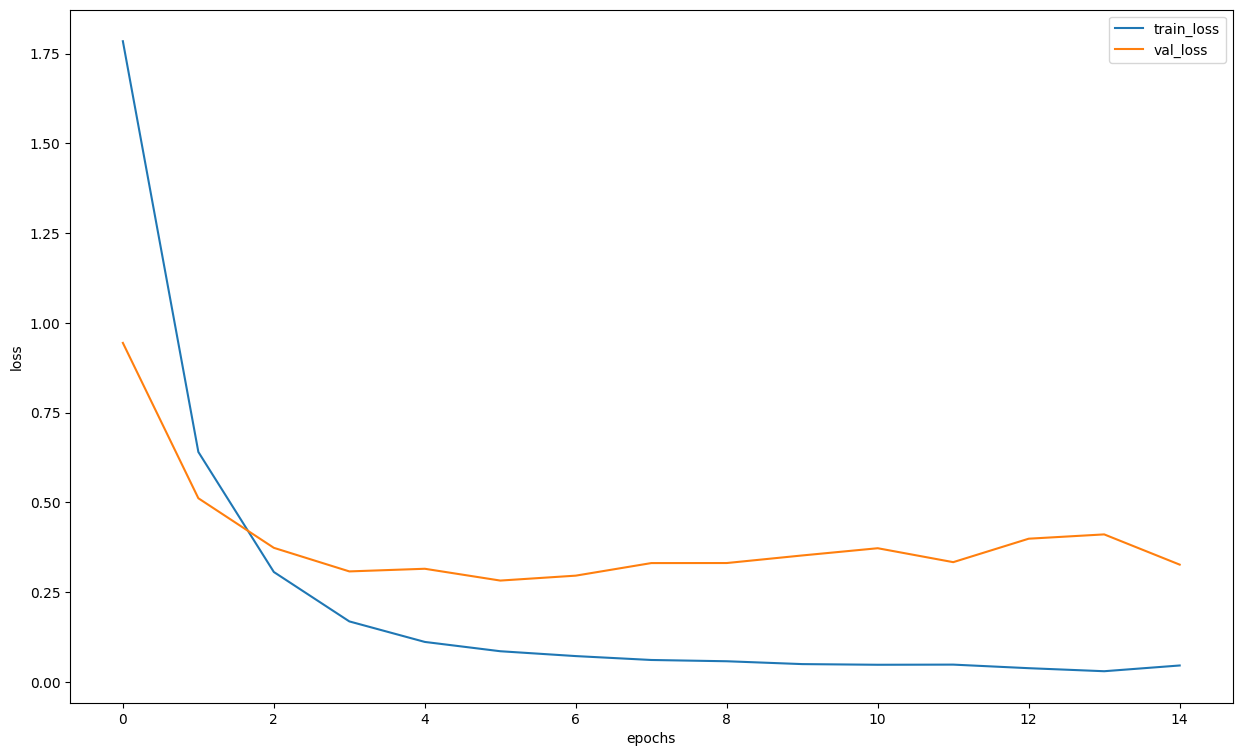

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

To improve the selected learning rate, we will use a scheduler (namely, CosineAnnealingLR, which was most often used for image classification tasks), which will give us the opportunity to dynamically change the value of the hyperparameter during the change of epochs (the added changes were made to the train function and noted by comments)\
Changing the batch_size hyperparameter has already been described in the previous paragraph\
To normalize the images of the dataset, transforms.Normalize from the torch library is already used, the parameters for which are taken from pretrained models on ImageNet

Besides that changes, we will also add Pooling and BatchNorm layers to each hidden layer of the neural network.
Also, I further increased the number of epochs, although the previous value of this parameter ALREADY improved the loss result that we achieve, but in my opinion, there is an opportunity to approach the "plateau" even more

In [ ]:
simple_cnn_2 = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn_2)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
history_cnn_2 = train(train_dataset, val_dataset, model=simple_cnn_2, epochs=18, batch_size=64)

epoch:   0%|          | 0/18 [00:00<?, ?it/s]

loss 1.3889286341839997


epoch:   6%|▌         | 1/18 [04:40<1:19:35, 280.92s/it]


Epoch 001 train_loss: 1.3889     val_loss 1.0016 train_acc 0.6267 val_acc 0.7313     before_lr 0.00100 after_lr 0.00098
loss 0.6017780994802505


epoch:  11%|█         | 2/18 [09:12<1:13:27, 275.46s/it]


Epoch 002 train_loss: 0.6018     val_loss 0.4919 train_acc 0.8328 val_acc 0.8666     before_lr 0.00098 after_lr 0.00090
loss 0.2936519120093679


epoch:  17%|█▋        | 3/18 [13:42<1:08:11, 272.80s/it]


Epoch 003 train_loss: 0.2937     val_loss 0.3762 train_acc 0.9167 val_acc 0.9015     before_lr 0.00090 after_lr 0.00079
loss 0.14276113498153578


epoch:  22%|██▏       | 4/18 [18:12<1:03:22, 271.62s/it]


Epoch 004 train_loss: 0.1428     val_loss 0.2758 train_acc 0.9589 val_acc 0.9321     before_lr 0.00079 after_lr 0.00065
loss 0.07569583870387236


epoch:  28%|██▊       | 5/18 [22:39<58:33, 270.28s/it]


Epoch 005 train_loss: 0.0757     val_loss 0.2267 train_acc 0.9781 val_acc 0.9502     before_lr 0.00065 after_lr 0.00050
loss 0.03057397480945746


epoch:  33%|███▎      | 6/18 [27:09<53:59, 269.98s/it]


Epoch 006 train_loss: 0.0306     val_loss 0.2033 train_acc 0.9918 val_acc 0.9641     before_lr 0.00050 after_lr 0.00035
loss 0.009935820347804873


epoch:  39%|███▉      | 7/18 [31:36<49:19, 269.01s/it]


Epoch 007 train_loss: 0.0099     val_loss 0.1935 train_acc 0.9984 val_acc 0.9688     before_lr 0.00035 after_lr 0.00021
loss 0.0033101506893383303


epoch:  44%|████▍     | 8/18 [36:05<44:51, 269.11s/it]


Epoch 008 train_loss: 0.0033     val_loss 0.1930 train_acc 0.9996 val_acc 0.9710     before_lr 0.00021 after_lr 0.00010
loss 0.0020107415260492375


epoch:  50%|█████     | 9/18 [40:34<40:19, 268.88s/it]


Epoch 009 train_loss: 0.0020     val_loss 0.1979 train_acc 0.9998 val_acc 0.9712     before_lr 0.00010 after_lr 0.00002
loss 0.0008687500464147907


epoch:  56%|█████▌    | 10/18 [45:01<35:48, 268.52s/it]


Epoch 010 train_loss: 0.0009     val_loss 0.1995 train_acc 0.9999 val_acc 0.9711     before_lr 0.00002 after_lr 0.00000
loss 0.0008067206648992096


epoch:  61%|██████    | 11/18 [49:31<31:22, 268.97s/it]


Epoch 011 train_loss: 0.0008     val_loss 0.1995 train_acc 0.9999 val_acc 0.9711     before_lr 0.00000 after_lr 0.00002
loss 0.0008025237233266468


epoch:  67%|██████▋   | 12/18 [54:01<26:55, 269.21s/it]


Epoch 012 train_loss: 0.0008     val_loss 0.2018 train_acc 0.9999 val_acc 0.9707     before_lr 0.00002 after_lr 0.00010
loss 0.0017331851876016672


epoch:  72%|███████▏  | 13/18 [58:32<22:28, 269.73s/it]


Epoch 013 train_loss: 0.0017     val_loss 0.2036 train_acc 0.9998 val_acc 0.9709     before_lr 0.00010 after_lr 0.00021
loss 0.023166343284058064


epoch:  78%|███████▊  | 14/18 [1:03:00<17:56, 269.15s/it]


Epoch 014 train_loss: 0.0232     val_loss 0.2081 train_acc 0.9932 val_acc 0.9671     before_lr 0.00021 after_lr 0.00035
loss 0.03145057298170673


epoch:  83%|████████▎ | 15/18 [1:07:29<13:27, 269.19s/it]


Epoch 015 train_loss: 0.0315     val_loss 0.2367 train_acc 0.9910 val_acc 0.9597     before_lr 0.00035 after_lr 0.00050
loss 0.05379943034702019


epoch:  89%|████████▉ | 16/18 [1:11:57<08:57, 268.85s/it]


Epoch 016 train_loss: 0.0538     val_loss 0.2525 train_acc 0.9833 val_acc 0.9533     before_lr 0.00050 after_lr 0.00065
loss 0.0740253001360374


epoch:  94%|█████████▍| 17/18 [1:16:25<04:28, 268.42s/it]


Epoch 017 train_loss: 0.0740     val_loss 0.2402 train_acc 0.9768 val_acc 0.9514     before_lr 0.00065 after_lr 0.00079
loss 0.061666565390558876


epoch: 100%|██████████| 18/18 [1:20:52<00:00, 269.58s/it]


Epoch 018 train_loss: 0.0617     val_loss 0.2827 train_acc 0.9817 val_acc 0.9461     before_lr 0.00079 after_lr 0.00090


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_cnn_2)

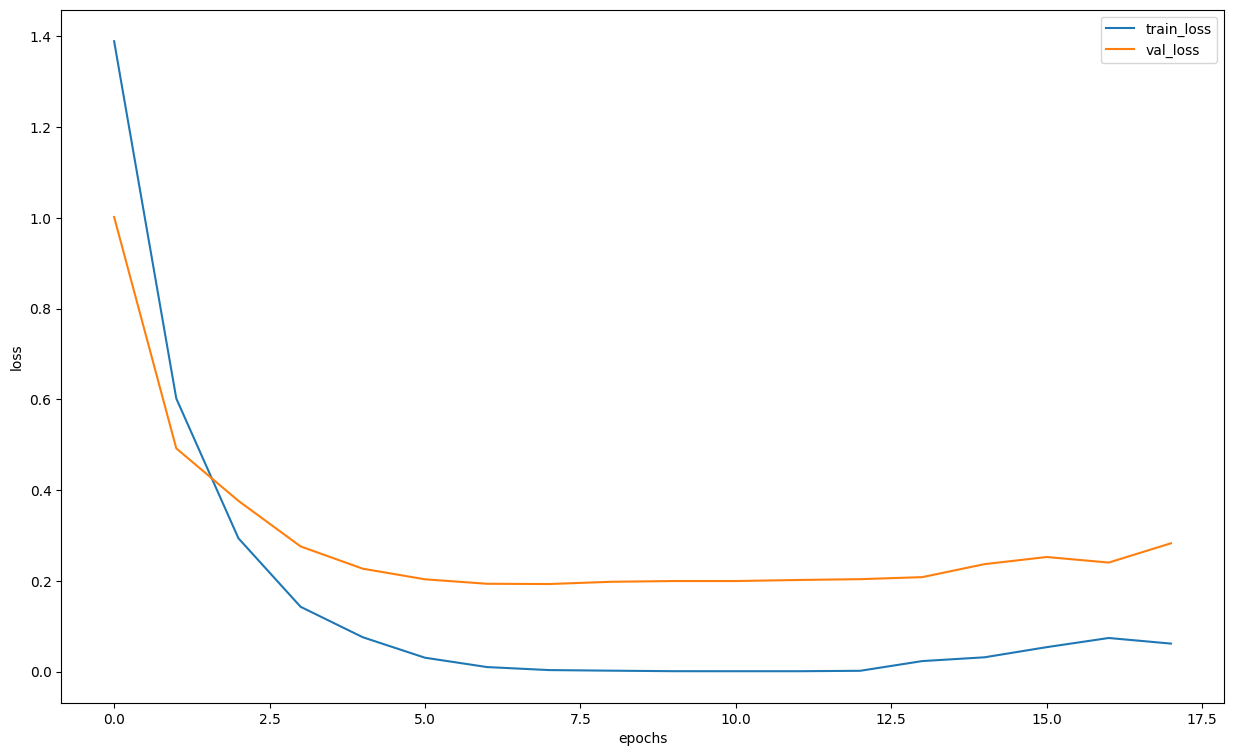

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

The optimizer value has been changed to AdamW in the train() function

In [ ]:
simple_cnn_3 = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn_3)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
history_cnn_3 = train(train_dataset, val_dataset, model=simple_cnn_3, epochs=16, batch_size=64)

epoch:   0%|          | 0/16 [00:00<?, ?it/s]

loss 1.3060983714299876


epoch:   6%|▋         | 1/16 [04:32<1:08:13, 272.93s/it]


Epoch 001 train_loss: 1.3061     val_loss 0.8392 train_acc 0.6470 val_acc 0.7689     before_lr 0.00100 after_lr 0.00098
loss 0.5834731046386713


epoch:  12%|█▎        | 2/16 [09:02<1:03:14, 271.04s/it]


Epoch 002 train_loss: 0.5835     val_loss 0.4221 train_acc 0.8375 val_acc 0.8876     before_lr 0.00098 after_lr 0.00090
loss 0.2843732971023794


epoch:  19%|█▉        | 3/16 [13:33<58:42, 270.94s/it]


Epoch 003 train_loss: 0.2844     val_loss 0.3200 train_acc 0.9193 val_acc 0.9128     before_lr 0.00090 after_lr 0.00079
loss 0.1485314331483081


epoch:  25%|██▌       | 4/16 [18:37<56:49, 284.15s/it]


Epoch 004 train_loss: 0.1485     val_loss 0.2461 train_acc 0.9575 val_acc 0.9338     before_lr 0.00079 after_lr 0.00065
loss 0.06208515675030923


epoch:  31%|███▏      | 5/16 [23:10<51:21, 280.11s/it]


Epoch 005 train_loss: 0.0621     val_loss 0.2064 train_acc 0.9821 val_acc 0.9509     before_lr 0.00065 after_lr 0.00050
loss 0.024977140682737438


epoch:  38%|███▊      | 6/16 [27:42<46:12, 277.27s/it]


Epoch 006 train_loss: 0.0250     val_loss 0.1726 train_acc 0.9931 val_acc 0.9665     before_lr 0.00050 after_lr 0.00035
loss 0.010036549572685913


epoch:  44%|████▍     | 7/16 [32:11<41:10, 274.53s/it]


Epoch 007 train_loss: 0.0100     val_loss 0.1738 train_acc 0.9982 val_acc 0.9705     before_lr 0.00035 after_lr 0.00021
loss 0.00381456486354936


epoch:  50%|█████     | 8/16 [36:41<36:24, 273.11s/it]


Epoch 008 train_loss: 0.0038     val_loss 0.1674 train_acc 0.9996 val_acc 0.9732     before_lr 0.00021 after_lr 0.00010
loss 0.0013269532352710772


epoch:  56%|█████▋    | 9/16 [41:11<31:45, 272.27s/it]


Epoch 009 train_loss: 0.0013     val_loss 0.1721 train_acc 0.9998 val_acc 0.9726     before_lr 0.00010 after_lr 0.00002
loss 0.0011733889443213243


epoch:  62%|██████▎   | 10/16 [45:41<27:08, 271.44s/it]


Epoch 010 train_loss: 0.0012     val_loss 0.1749 train_acc 0.9998 val_acc 0.9730     before_lr 0.00002 after_lr 0.00000
loss 0.0006910747241188717


epoch:  69%|██████▉   | 11/16 [50:11<22:35, 271.02s/it]


Epoch 011 train_loss: 0.0007     val_loss 0.1749 train_acc 0.9999 val_acc 0.9730     before_lr 0.00000 after_lr 0.00002
loss 0.0007895236337629837


epoch:  75%|███████▌  | 12/16 [54:40<18:00, 270.23s/it]


Epoch 012 train_loss: 0.0008     val_loss 0.1763 train_acc 0.9999 val_acc 0.9726     before_lr 0.00002 after_lr 0.00010
loss 0.0008478093645268017


epoch:  81%|████████▏ | 13/16 [59:10<13:31, 270.37s/it]


Epoch 013 train_loss: 0.0008     val_loss 0.1813 train_acc 0.9999 val_acc 0.9729     before_lr 0.00010 after_lr 0.00021
loss 0.02088658898717872


epoch:  88%|████████▊ | 14/16 [1:03:40<09:00, 270.23s/it]


Epoch 014 train_loss: 0.0209     val_loss 0.1747 train_acc 0.9939 val_acc 0.9725     before_lr 0.00021 after_lr 0.00035
loss 0.04132222190487204


epoch:  94%|█████████▍| 15/16 [1:08:08<04:29, 269.62s/it]


Epoch 015 train_loss: 0.0413     val_loss 0.2098 train_acc 0.9880 val_acc 0.9616     before_lr 0.00035 after_lr 0.00050
loss 0.05659057122946394


epoch: 100%|██████████| 16/16 [1:12:38<00:00, 272.40s/it]


Epoch 016 train_loss: 0.0566     val_loss 0.2342 train_acc 0.9828 val_acc 0.9528     before_lr 0.00050 after_lr 0.00065


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_cnn_3)

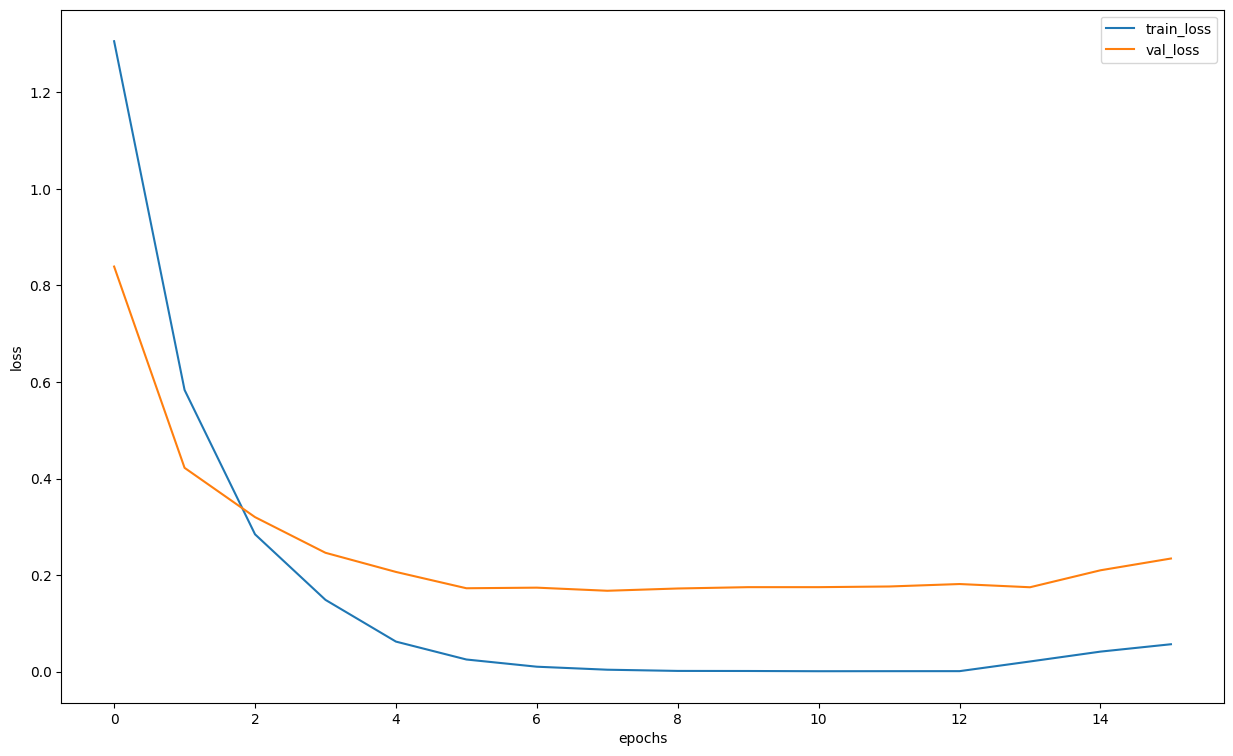

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn_3, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn_3, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1 score:", f1)

F1 score: 0.95


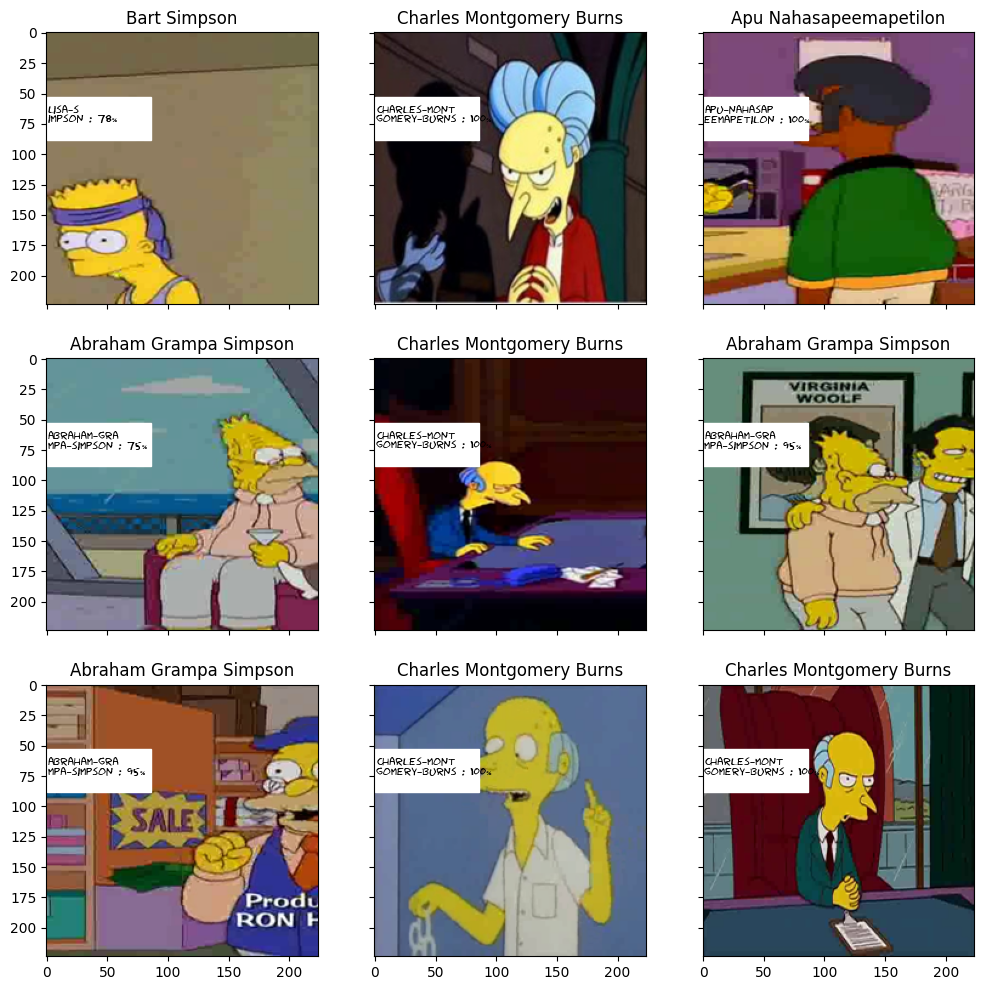

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn_3, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

The maximum value for the f1 metric is 0.95, which we obtained by improving the base CNN model with various methods

From now on, we will try resnet and inception models, rather than changing default cnn architecture

In [ ]:
import torch
import torchvision

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
fc_layer = nn.Linear(resnet18.fc.in_features, n_classes)
resnet18.fc = fc_layer

In [ ]:
resnet18 = resnet18.to(DEVICE)

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history_resnet18_1 = train(train_dataset, val_dataset, model=resnet18, epochs=14, batch_size=64)

epoch:   0%|          | 0/14 [00:00<?, ?it/s]

loss 0.41676650836585893


epoch:   7%|▋         | 1/14 [05:53<1:16:37, 353.66s/it]


Epoch 001 train_loss: 0.4168     val_loss 0.3256 train_acc 0.8946 val_acc 0.9166     before_lr 0.00100 after_lr 0.00098
loss 3.1226519646661752


epoch:  14%|█▍        | 2/14 [11:14<1:06:50, 334.21s/it]


Epoch 002 train_loss: 3.1227     val_loss 3.0323 train_acc 0.1084 val_acc 0.1078     before_lr 0.00098 after_lr 0.00090
loss 2.589685669749887


epoch:  21%|██▏       | 3/14 [16:34<1:00:08, 328.02s/it]


Epoch 003 train_loss: 2.5897     val_loss 1.8409 train_acc 0.2505 val_acc 0.4689     before_lr 0.00090 after_lr 0.00079
loss 1.3587649129064163


epoch:  29%|██▊       | 4/14 [21:54<54:05, 324.50s/it]


Epoch 004 train_loss: 1.3588     val_loss 0.9393 train_acc 0.6200 val_acc 0.7396     before_lr 0.00079 after_lr 0.00065
loss 0.7394152575313462


epoch:  36%|███▌      | 5/14 [27:14<48:29, 323.22s/it]


Epoch 005 train_loss: 0.7394     val_loss 0.6470 train_acc 0.7919 val_acc 0.8171     before_lr 0.00065 after_lr 0.00050
loss 0.45060650964402715


epoch:  43%|████▎     | 6/14 [32:36<42:59, 322.48s/it]


Epoch 006 train_loss: 0.4506     val_loss 0.4303 train_acc 0.8711 val_acc 0.8832     before_lr 0.00050 after_lr 0.00035
loss 0.25214109218531744


epoch:  50%|█████     | 7/14 [37:58<37:37, 322.52s/it]


Epoch 007 train_loss: 0.2521     val_loss 0.3028 train_acc 0.9292 val_acc 0.9203     before_lr 0.00035 after_lr 0.00021
loss 0.12548214012810394


epoch:  57%|█████▋    | 8/14 [43:22<32:17, 322.88s/it]


Epoch 008 train_loss: 0.1255     val_loss 0.2256 train_acc 0.9653 val_acc 0.9492     before_lr 0.00021 after_lr 0.00010
loss 0.05301587019676752


epoch:  64%|██████▍   | 9/14 [48:47<26:57, 323.55s/it]


Epoch 009 train_loss: 0.0530     val_loss 0.2037 train_acc 0.9866 val_acc 0.9607     before_lr 0.00010 after_lr 0.00002
loss 0.024100181405709586


epoch:  71%|███████▏  | 10/14 [54:09<21:32, 323.10s/it]


Epoch 010 train_loss: 0.0241     val_loss 0.1965 train_acc 0.9950 val_acc 0.9664     before_lr 0.00002 after_lr 0.00000
loss 0.01817991632352783


epoch:  79%|███████▊  | 11/14 [59:31<16:08, 322.69s/it]


Epoch 011 train_loss: 0.0182     val_loss 0.1965 train_acc 0.9967 val_acc 0.9664     before_lr 0.00000 after_lr 0.00002
loss 0.017555297205314863


epoch:  86%|████████▌ | 12/14 [1:04:51<10:43, 321.92s/it]


Epoch 012 train_loss: 0.0176     val_loss 0.2070 train_acc 0.9966 val_acc 0.9682     before_lr 0.00002 after_lr 0.00010
loss 0.03285097618946479


epoch:  93%|█████████▎| 13/14 [1:10:12<05:21, 321.80s/it]


Epoch 013 train_loss: 0.0329     val_loss 0.2302 train_acc 0.9911 val_acc 0.9605     before_lr 0.00010 after_lr 0.00021
loss 0.07981071167723754


epoch: 100%|██████████| 14/14 [1:15:32<00:00, 323.75s/it]


Epoch 014 train_loss: 0.0798     val_loss 0.2141 train_acc 0.9750 val_acc 0.9565     before_lr 0.00021 after_lr 0.00035


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_resnet18_1)

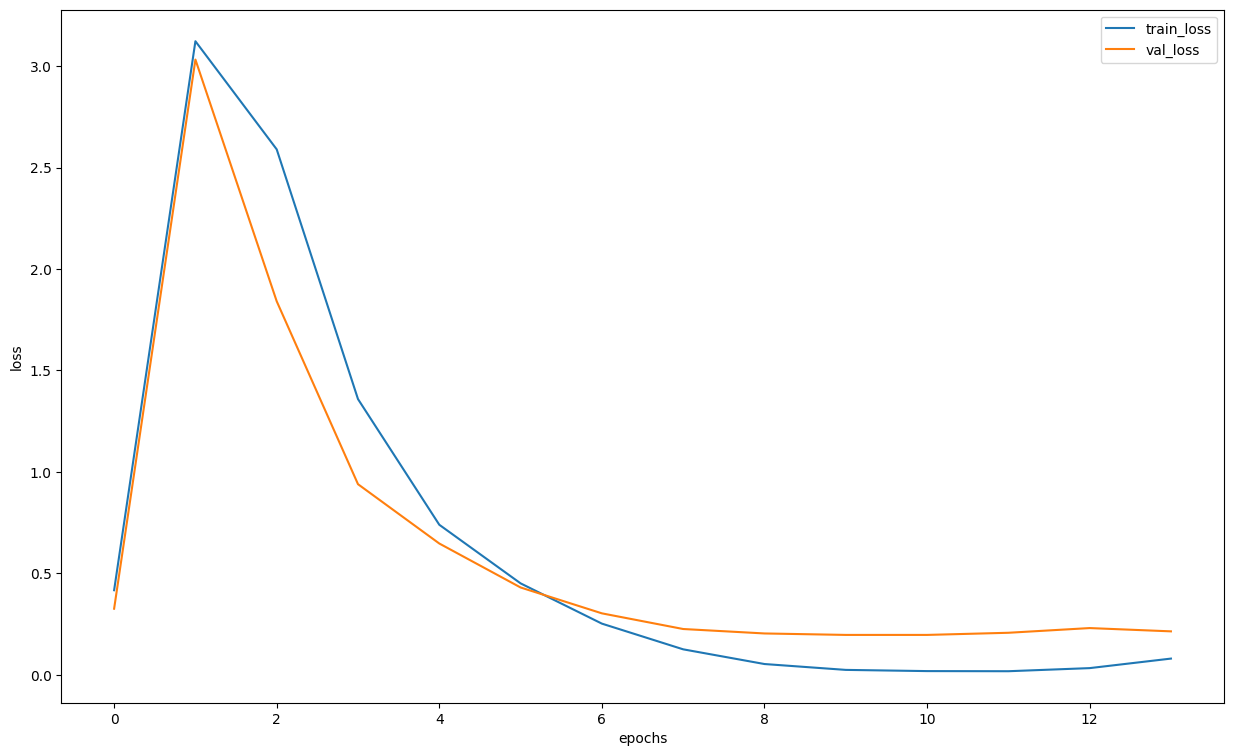

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet18, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet18, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1 score:", f1)

F1 score: 0.95


In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet18, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Also, the technique called augmentation can be useful here

The number of images in the training dataset before augmentation

In [ ]:
train_dataset.len_

31399

To accomplish this task, I modified the logic of the SimpsonsDataset class, where now, each image included in the training sample will be augmented

The number of images in the training dataset after augmentation

In [27]:
train_dataset.len_

62798

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,60000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

We see that the augmentation was successful, since among the original images there are those that are modified

In [28]:
simple_cnn_4 = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn_4)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [29]:
history_cnn_4 = train(train_dataset, val_dataset, model=simple_cnn_4, epochs=16, batch_size=128)

epoch:   0%|          | 0/16 [00:00<?, ?it/s]

loss 1.4464513088678144


epoch:   6%|▋         | 1/16 [09:07<2:16:53, 547.54s/it]


Epoch 001 train_loss: 1.4465     val_loss 0.8336 train_acc 0.6067 val_acc 0.7762     before_lr 0.00100 after_lr 0.00098
loss 0.8690762629633956


epoch:  12%|█▎        | 2/16 [18:06<2:06:31, 542.26s/it]


Epoch 002 train_loss: 0.8691     val_loss 0.5064 train_acc 0.7627 val_acc 0.8615     before_lr 0.00098 after_lr 0.00090
loss 0.45907938746328686


epoch:  19%|█▉        | 3/16 [27:12<1:57:56, 544.35s/it]


Epoch 003 train_loss: 0.4591     val_loss 0.3552 train_acc 0.8721 val_acc 0.9051     before_lr 0.00090 after_lr 0.00079
loss 0.31822949906831227


epoch:  25%|██▌       | 4/16 [36:13<1:48:35, 542.94s/it]


Epoch 004 train_loss: 0.3182     val_loss 0.2440 train_acc 0.9111 val_acc 0.9421     before_lr 0.00079 after_lr 0.00065
loss 0.2342739010528036


epoch:  31%|███▏      | 5/16 [45:18<1:39:38, 543.50s/it]


Epoch 005 train_loss: 0.2343     val_loss 0.2193 train_acc 0.9343 val_acc 0.9499     before_lr 0.00065 after_lr 0.00050
loss 0.1846383494973399


epoch:  38%|███▊      | 6/16 [54:25<1:30:47, 544.79s/it]


Epoch 006 train_loss: 0.1846     val_loss 0.1864 train_acc 0.9491 val_acc 0.9604     before_lr 0.00050 after_lr 0.00035
loss 0.14526023957886064


epoch:  44%|████▍     | 7/16 [1:03:25<1:21:29, 543.29s/it]


Epoch 007 train_loss: 0.1453     val_loss 0.1670 train_acc 0.9600 val_acc 0.9679     before_lr 0.00035 after_lr 0.00021
loss 0.11863491861095983


epoch:  50%|█████     | 8/16 [1:12:30<1:12:30, 543.86s/it]


Epoch 008 train_loss: 0.1186     val_loss 0.1567 train_acc 0.9673 val_acc 0.9734     before_lr 0.00021 after_lr 0.00010
loss 0.09811099672466331


epoch:  56%|█████▋    | 9/16 [1:21:34<1:03:26, 543.84s/it]


Epoch 009 train_loss: 0.0981     val_loss 0.1511 train_acc 0.9732 val_acc 0.9746     before_lr 0.00010 after_lr 0.00002
loss 0.0852393111723438


epoch:  62%|██████▎   | 10/16 [1:30:34<54:16, 542.70s/it]


Epoch 010 train_loss: 0.0852     val_loss 0.1474 train_acc 0.9756 val_acc 0.9767     before_lr 0.00002 after_lr 0.00000
loss 0.08653826279103397


epoch:  69%|██████▉   | 11/16 [1:39:40<45:17, 543.54s/it]


Epoch 011 train_loss: 0.0865     val_loss 0.1474 train_acc 0.9755 val_acc 0.9767     before_lr 0.00000 after_lr 0.00002
loss 0.08261642229749146


epoch:  75%|███████▌  | 12/16 [1:48:36<36:05, 541.25s/it]


Epoch 012 train_loss: 0.0826     val_loss 0.1494 train_acc 0.9765 val_acc 0.9760     before_lr 0.00002 after_lr 0.00010
loss 0.0887583486818634


epoch:  81%|████████▏ | 13/16 [1:57:39<27:05, 541.94s/it]


Epoch 013 train_loss: 0.0888     val_loss 0.1445 train_acc 0.9757 val_acc 0.9772     before_lr 0.00010 after_lr 0.00021
loss 0.10182630466552649


epoch:  88%|████████▊ | 14/16 [2:06:43<18:05, 542.51s/it]


Epoch 014 train_loss: 0.1018     val_loss 0.1526 train_acc 0.9719 val_acc 0.9739     before_lr 0.00021 after_lr 0.00035
loss 0.11601237365281021


epoch:  94%|█████████▍| 15/16 [2:15:43<09:01, 541.77s/it]


Epoch 015 train_loss: 0.1160     val_loss 0.1764 train_acc 0.9668 val_acc 0.9711     before_lr 0.00035 after_lr 0.00050
loss 0.1377357530935186


epoch: 100%|██████████| 16/16 [2:24:54<00:00, 543.39s/it]


Epoch 016 train_loss: 0.1377     val_loss 0.1788 train_acc 0.9600 val_acc 0.9656     before_lr 0.00050 after_lr 0.00065


In [30]:
loss, acc, val_loss, val_acc = zip(*history_cnn_4)

In [31]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [32]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn_4, ex_img.unsqueeze(0))

In [34]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn_4, imgs)

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [36]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1 score:", f1)

F1 score: 0.96


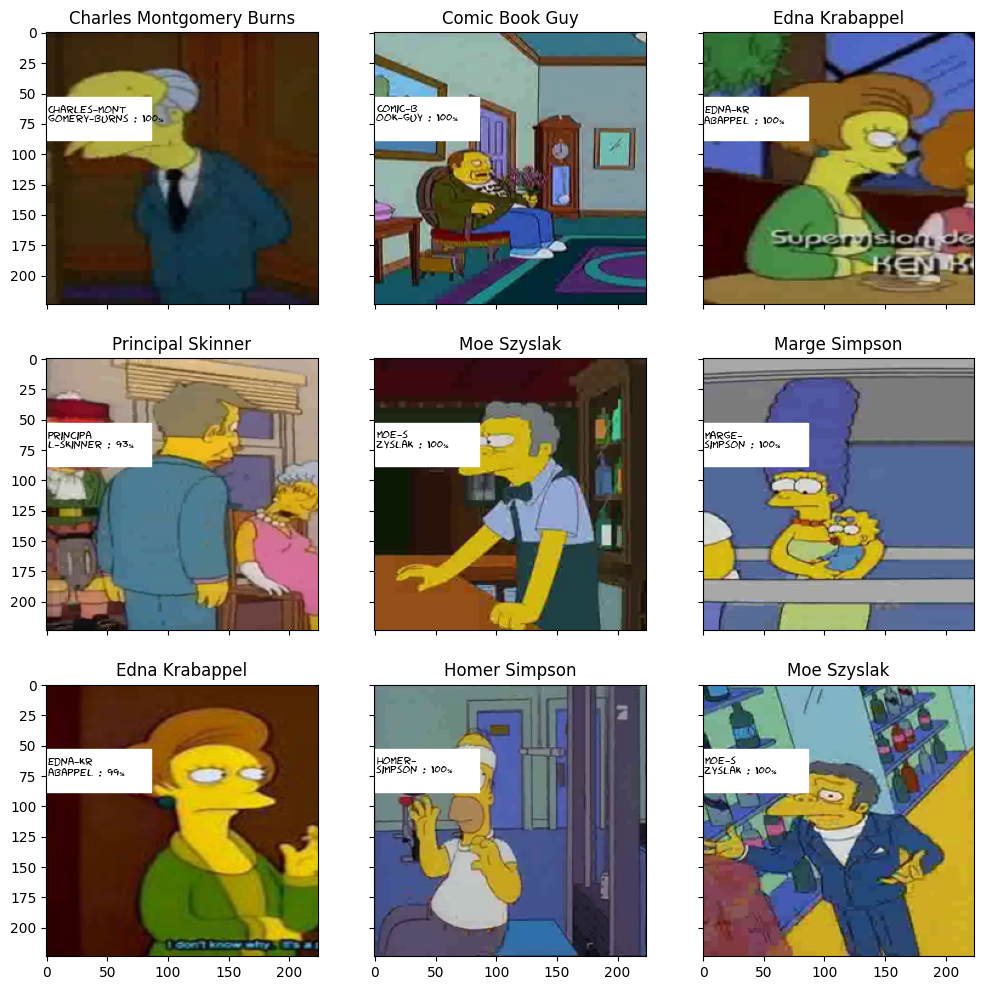

In [39]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,60000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn_4, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

As you can see, using the custom CNN model, we achieved a fairly high accuracy result of 95-97% on the validation dataset, as well as the pretrained ResNet model, which was additionally trained on our data.\
From the experiments, we saw the importance of using such techniques as dynamic learning_rate, augmentation,
the selection of hyperparameters of the models and the improvements made by the application of these changes.